In [1]:
import awkward as awk
import matplotlib.pyplot as plt
import numpy as np

In [35]:
f = "output/IceCube_DIS.parquet"
data = awk.from_parquet(f)

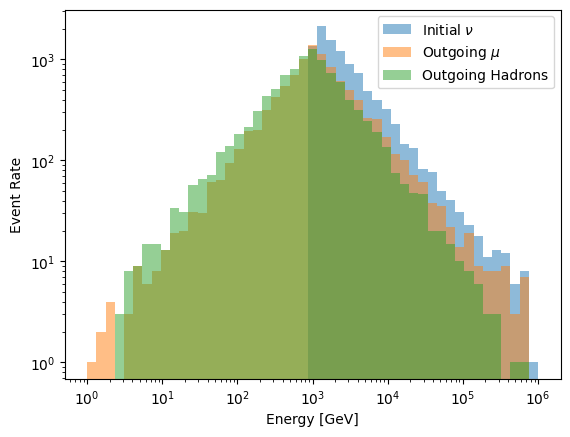

In [36]:
# kinematics

nu_momenta = np.squeeze(data["primary_momentum"])

# muon
mu_flag = data["secondary_types"]=='ParticleType.MuMinus'
mu_momenta = np.squeeze(data["secondary_momenta"][mu_flag])

# nu out
target_flag = data["secondary_types"]=='ParticleType.Hadrons'
target_momenta = np.squeeze(data["secondary_momenta"][target_flag])

kwargs = {"bins":np.logspace(0,6,50),
          #"weights":data["event_weight"],
          "alpha":0.5}

# Energy
plt.hist(nu_momenta[:,0],**kwargs,label=r"Initial $\nu$")
plt.hist(mu_momenta[:,0],**kwargs,label=r"Outgoing $\mu$")
plt.hist(target_momenta[:,0],**kwargs,label=r"Outgoing Hadrons")
plt.legend()
plt.loglog()
plt.xlabel("Energy [GeV]")
plt.ylabel("Event Rate")
plt.show()